https://people.revoledu.com/kardi/tutorial/Python/Video+Analysis+using+OpenCV-Python.html#:~:text=Video%20Analysis%20using%20OpenCV%2DPython&text=This%20tutorial%20is%20a%20practice,numpy%20and%20math%20modules%20installed.

In [328]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [329]:
cap = cv2.VideoCapture('..//assets//videos//juggling.mp4')
vs = cap

In [330]:
w = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('Height and Width of the frame {} {}'.format(h, w))

Height and Width of the frame 2160 3840


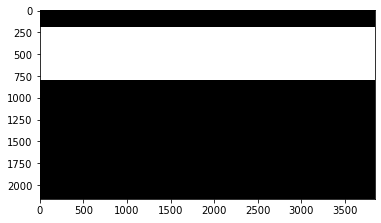

In [331]:
base_mask = np.zeros((h, w))
base_mask[200:800] = 1
plt.imshow(base_mask, cmap = 'gray')
plt.show()

In [332]:
hsv_lower = (0, 48, 0)
hsv_higher = (180, 255, 75)

In [333]:
def processAndShow(vs, func = None):
        
    while vs.isOpened():
        ret, fr = vs.read()
        
        if ret == False:
            break
        f = 0.2
        fr = cv2.resize(fr, (int(vs.get(cv2.CAP_PROP_FRAME_WIDTH)*f), int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT)*f)), fx = f, fy = f)
        if func is not None:
            fr = func(fr)
        
        cv2.imshow('frame', fr)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
#     vs.release()
    cv2.destroyAllWindows()

In [334]:
def closest_node(node, nodes):
    nodes = np.asarray(list(nodes))
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

def proc(fr, backSub = cv2.createBackgroundSubtractorMOG2()):
    fr_ = backSub.apply(fr)
    
    fr_ = cv2.erode(fr_, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 5)
    fr_ = cv2.dilate(fr_, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 5)
    
    skin = cv2.inRange(fr, (0, 70, 0), (25, 170, 255))
    skin_ = cv2.bitwise_not(skin)
    
    fr_ = cv2.bitwise_and(fr_, fr_, mask = skin)
    
    contours, hierarchy = cv2.findContours(fr_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    far_centers = set()
    for c in contours:
        contours_poly = cv2.approxPolyDP(c, 3, True)
        boundRect = cv2.boundingRect(contours_poly)
        center, radius = cv2.minEnclosingCircle(contours_poly)
        if radius > 30:
            if len(far_centers) == 0:
                far_centers.add(center)
                cv2.circle(fr, (int(center[0]), int(center[1])), int(radius), [255, 0, 0], thickness = 10)
            else:
                if closest_node(center, far_centers) > 0.1:
                    far_centers.add(center)
                    cv2.circle(fr, (int(center[0]), int(center[1])), int(radius), [255, 0, 0], thickness = 10)

    return skin

In [335]:
processAndShow(vs, proc)